### Overview

In financial risk management, Value-at-Risk (VaR) is a commonly used risk measure, which tries to answer the following question: What loss is such that it will only be exceeded 100p% of the time in the next K trading days? Many techniques have been developed to estimate VaR. This notebook will demostrate several techniques to calculate VaR of the portfolio consisting of just one security -- Hang Seng Index fund.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arch
import datetime
from scipy.stats import norm

### Data

The HSI data from year 2010 to 2021 is used in this notebook. It is assumed that the return of the portfolio is the same as that of HSI. The data is obtained from Yahoo Finance

In [2]:
df_hsi = pd.read_csv('HSI_2010_2021.csv')
df_hsi['Date'] = pd.to_datetime(df_hsi['Date'], format='%Y-%m-%d')
df_hsi.dropna(inplace=True)
df_hsi

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,21860.039063,22024.830078,21689.220703,21823.279297,21823.279297,1.006200e+09
1,2010-01-05,22092.150391,22297.039063,21987.269531,22279.580078,22279.580078,1.965585e+09
2,2010-01-06,22357.460938,22514.789063,22277.130859,22416.669922,22416.669922,2.100234e+09
3,2010-01-07,22548.029297,22548.029297,22169.609375,22269.449219,22269.449219,1.495365e+09
4,2010-01-08,22282.750000,22443.220703,22206.160156,22296.750000,22296.750000,1.626023e+09
...,...,...,...,...,...,...,...
2957,2021-12-23,23141.789063,23264.750000,23027.150391,23193.640625,23193.640625,1.387904e+09
2958,2021-12-24,23375.990234,23383.189453,23186.570313,23223.759766,23223.759766,6.228797e+08
2959,2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547,1.433027e+09
2960,2021-12-29,23253.980469,23253.980469,23008.279297,23086.539063,23086.539063,8.284144e+08


## Model-free Methods

### Historical Simulation

Historical simulation is a non-parametric method which assumes that the distribution of tomorrow's portfolio returns is approximated by the empirical distribution of the past N observations.

For example, suppose N = 250. In order to calculate the 1% VaR of return on day 251, we need to find the 1st percentile of return between day 1 and day 250.

##### Note: VaR is treated as negative value in this notebook (although it is defined as positive number by convention)

In [3]:
def historical_simulation(df, N = 250, p=0.01):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The price/index data containing column name 'Close'
    N: int
        Calculate VaR by using past N daily returns
    p: float
        To calculate 100p% VaR
        
    Returns
    ----------
    pd.DataFrame
        DataFrame with new colums 'VaR_hs' specifying VaR of return 
    '''
    df['Return'] = np.log(df['Close']/df['Close'].shift(1))
    df.dropna(inplace = True)
    df['tmr_VaR_hs'] = df['Return'].rolling(window=N).apply(lambda x: np.quantile(x, p)) #calculate tomorrow's VaR
    df['VaR_hs'] = df['tmr_VaR_hs'].shift(1)
    return df

N = 250, p = 0.01. Percentage of day with return smaller than VaR = 0.018484288354898338
N = 500, p = 0.01. Percentage of day with return smaller than VaR = 0.013441955193482688
N = 750, p = 0.01. Percentage of day with return smaller than VaR = 0.013605442176870748
N = 1000, p = 0.01. Percentage of day with return smaller than VaR = 0.011253196930946292


Text(0.5, 1.0, '1-day VaR')

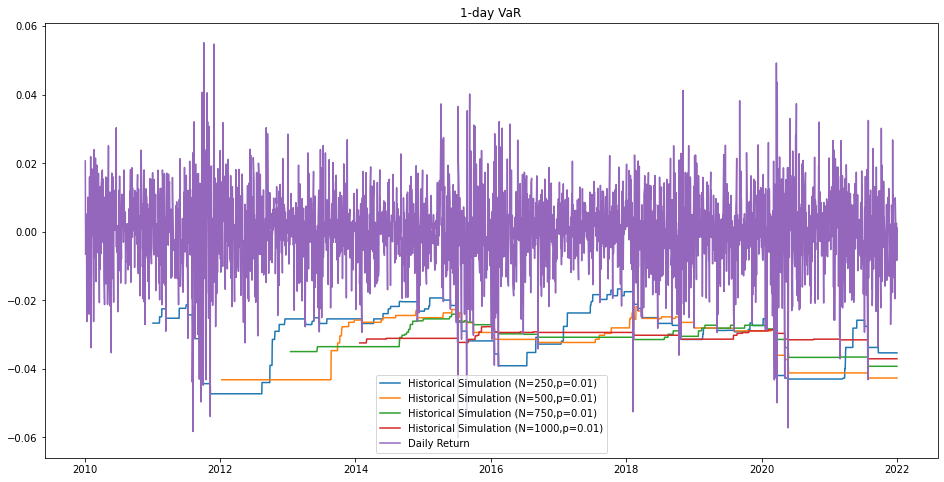

In [4]:
# Visualize the result by using different number of past observations (i.e. N) to calculate VaR

fig, ax = plt.subplots(figsize=(16,8))
for N, p in [(250,0.01),(500,0.01),(750,0.01), (1000,0.01)]:
    df_hs = df_hsi.copy(deep=True)
    df_hs = historical_simulation(df_hs, N, p)
    num_below = len(np.where(df_hs['Return']<df_hs['VaR_hs'])[0])
    num_above = len(np.where(df_hs['Return']>=df_hs['VaR_hs'])[0])
    print('N = {}, p = {}. Percentage of day with return smaller than VaR = {}'.format(N,p,num_below/(num_below+num_above)))
    ax.plot(df_hs['Date'], df_hs['VaR_hs'], label='Historical Simulation (N={},p={})'.format(N,p))
ax.plot(df_hs['Date'],df_hs['Return'], label='Daily Return')
plt.legend()
plt.title('1-day VaR')

Notice that the smaller value of N, the more dynamic patterns of VaR (i.e. more responsive to the most recent return). Also, although 1% VaR is calculated, the percentage of day with return smaller than VaR is higher than 1%. This shows that historical simulation VaR tends to overestimate risk when the market volatility is low, and underestimate risk when the market volatility is high.

### Age-Weighted Historical Simulation

Age-Weighted Historical Simulation is also a non-parametric method which is similar to Historical Simulation. The difference is that more weight is assigned to the most recent observations and relatively less weight to the returns further in the past. For example, suppose we look back N=250 days to estimate the VaR on day 251. The weight of return on day (251-i) is (W^(i-1))*(1-W)/(1-W^250) for i = 1,2,...,250, where W is a depreciating factor and 0<W<1 . Then the observations along with their assigned weights are sorted in ascending order. Finally, the 100p% VaR is calculated by accumulating the weights of the ascending returns until 100p% is reached. 


In [5]:
def weighted_historical_simulation(df, N = 250, W = 0.99, p = 0.01):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The price/index data containing column name 'Close'
    N: int
        Calculate VaR by using past N daily returns
    W: float
        Depreciating factor for calculating the weight
    p: float
        To calculate 100p% VaR
        
    Returns
    ----------
    pd.DataFrame
        DataFrame with new colums 'VaR_whs' specifying VaR of return
    '''
    df['Return'] = np.log(df['Close']/df['Close'].shift(1))
    df.dropna(inplace = True)
    def helper(x):
        '''
        Parameters
        -----------
        x: array
            array of column 'Return' from df

        Returns
        ----------
        float
            VaR of return
        '''
        weights = W ** (np.arange(N,0,-1) - 1)*(1 - W)/(1 - W** N) 
        sorted_return = np.sort(x)
        sorted_weights = weights[np.argsort(x)]  # sort the weight by ascending order of return
        idx = np.where(sorted_weights.cumsum()<=p)[0] # find the index of sorted_return such that cummulated sum of their weights is smaller than p
        if len(idx) == 0: 
            return sorted_return[0]
        else:
            return sorted_return[np.max(idx)]
    df['tmr_VaR_whs'] = df['Return'].rolling(window = N).apply(helper)
    df['VaR_whs'] = df['tmr_VaR_whs'].shift(1)
    return df
    
    
    

N = 250, W = 0.99. Percentage of day with return smaller than VaR = 0.009611829944547136
N = 250, W = 0.95. Percentage of day with return smaller than VaR = 0.02144177449168207
N = 500, W = 0.99. Percentage of day with return smaller than VaR = 0.009775967413441956
N = 500, W = 0.95. Percentage of day with return smaller than VaR = 0.021588594704684317


Text(0.5, 1.0, '1-day 1% VaR')

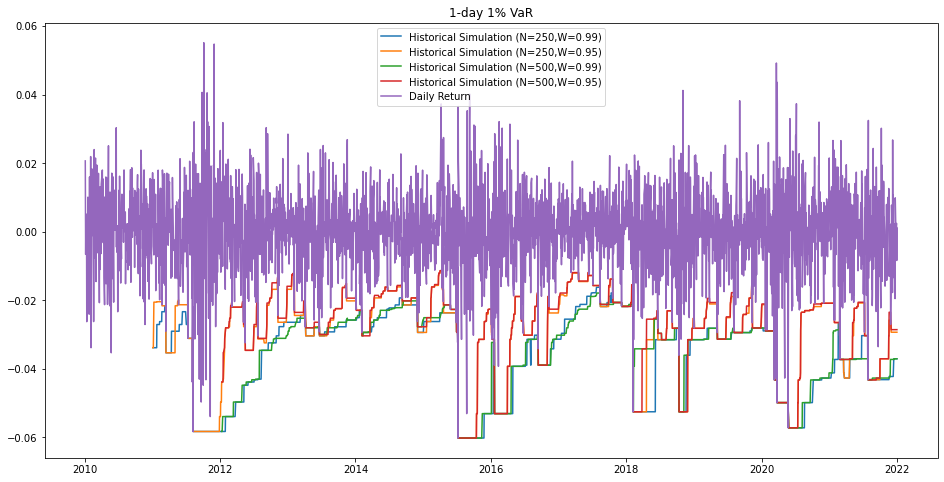

In [6]:
# Visualize the result by using different number of past observations (N) and depreciating factor (W) to calculate VaR

fig, ax = plt.subplots(figsize=(16,8))
for N, W in [(250,0.99),(250,0.95),(500,0.99), (500, 0.95)]:
    df_whs = df_hsi.copy(deep=True)
    df_whs = weighted_historical_simulation(df_whs, N, W)
    num_below = len(np.where(df_whs['Return']<df_whs['VaR_whs'])[0])
    num_above = len(np.where(df_whs['Return']>=df_whs['VaR_whs'])[0])
    print('N = {}, W = {}. Percentage of day with return smaller than VaR = {}'.format(N,W,num_below/(num_below+num_above)))
    ax.plot(df_whs['Date'], df_whs['VaR_whs'], label='Historical Simulation (N={},W={})'.format(N,W))
ax.plot(df_whs['Date'],df_whs['Return'], label='Daily Return')
plt.legend()
plt.title('1-day 1% VaR')

Note that smaller W (depreciating factor) tends to produce more dynamic pattern of VaR as the depreciating rate increases when W decreases. Therefore, more weight is assigned to more current return and VaR is more responsive to the most recent return. However, the change in N (number of past observations used to calculate VaR) has less effect on VaR when compared with W. 

## Model-based Methods

### VaR Forecasting by GARCH Model

Although non-parametric methods like Historical Simulation is easy to compute, it has several disavantages. For example, the VaR you get from Historical Simulation can never be greater than maximum loss in the historical data, which is not the case in reality. Therefore, it is also common to use parametric methods to estimate the VaR. A common method is to assume that the daily return is normally distributed. Then we can estimate the VaR by {mean_return + z * standard_deviation_of_return}, where z is the 100p-percentile of normal distribution. The mean_return and standard_deviation can vary time to time but historical data tell us that daily mean_return tends to be a constant close to zero . Therefore, it is more important to model the change of volatility so as to better estimate the VaR of return. 

GARCH(1,1) model is a classic model for modelling the variance dynamics. It assumes that next day's variance is linear combination of square of today's return and today's variance (i.e. Variance{t+1} = omega + alpha * Return{t}^2 + Beta * Variance{t}, where omega, alpha and beta are parameters that can be optimized through Maximum Likelihood Estimation). By using the estimation of next day's variance, we can forecast the VaR of return on next day given that the daily return is assumed to be normally distributed. 

The following code will use a rolling window of size m to train a GARCH model by using past m data. Then it will estimate next day's variance and hence calculating the VaR on next day.

In [ ]:
def GARCH_VaR(df, split_date, p = 0.01):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The price/index data containing column name 'Close'
    split_date: str or datetime obj
        The data before split_date is used to estimate parameters in GARCH model.
        Then the forecasts will be produced for the date after the split_date.
    p: float
        To calculate 100p% VaR
        
    Returns
    ----------
    pd.DataFrame
        DataFrame with new colums 'VaR_GARCH' specifying VaR of return
    '''
    z = norm.ppf(p) # calculate 100p-percentile of Normal distribution
    df['Return'] = np.log(df['Close']/df['Close'].shift(1))
    df.dropna(inplace=True)
    def helper(x):
        '''
        Parameters
        -----------
        x: pd.DataFrame
            The price/index data containing column name 'Return'

        Returns
        ----------
        float
            VaR of return one day ahead the last date in x
        '''
        ret = x.set_index('Date')['Return'] 
        model = arch.arch_model(ret, rescale=False)
        res = model.fit(last_obs=ret.index[-1]) # use all data to fit the model
        forecasts = res.forecast(horizon=5, start=ret.index[0], reindex=False) 
        tmr_variance = forecasts.variance['h.1'].reset_index() # one day ahead estimation for variance
        last_variance = tmr_variance.iloc[-1,1] # estimated variance on next day of last date in x
        return last_variance**0.5 * z
    tmr_VaR_filtered_hs = []
    for i in df.rolling(window=m):
        if len(i)<m: # if do not have enough number of past data
            tmr_VaR_filtered_hs.append(np.nan)
        else:
            tmr_VaR_filtered_hs.append(helper(i))
    df['tmr_VaR_GARCH'] = tmr_VaR_filtered_hs
    df['VaR_GARCH'] = df['tmr_VaR_GARCH'].shift(1)
    return df

In [ ]:
df_GARCH = df_hsi.copy(deep=True)
m = 500 # number of past data
df_GARCH = GARCH_VaR(df_GARCH, m)

Percentage of day with return smaller than VaR = 0.024032586558044806


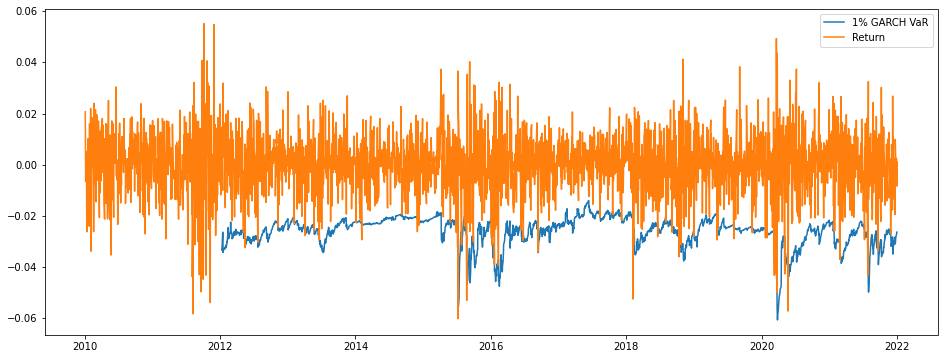

In [9]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(df_GARCH['Date'], df_GARCH['VaR_GARCH'], label = '1% GARCH VaR')
ax.plot(df_GARCH['Date'], df_GARCH['Return'], label = 'Return')
plt.legend()
num_below = len(np.where(df_GARCH['Return']<df_GARCH['VaR_GARCH'])[0])
num_above = len(np.where(df_GARCH['Return']>=df_GARCH['VaR_GARCH'])[0])
print('Percentage of day with return smaller than VaR = {}'.format(num_below/(num_below+num_above)))

From the figure above, we can see that GARCH VaR response quickly to the change in market volatility. The VaR of return drops significantly when the daily return greatly deviate from zero. Then the VaR also increases quickly when the daily restores to normal level. Therefore, unlike Historical Simulation method, GARCH VaR is able to capture the significant change in market volatility while avoid overestimating the loss when market volatility is small.

### Filtered Historical Simulation Approach

The Filtered Historical Simulation approach attempts to combine both model-based and model-free methods to estimate VaR. The algorithm looks like this. For each date in the data, we first fit a GARCH model to past m historical data before that date. Then we divide the past return by standard deviation estimated from GARCH model to obtain standardized returns. After that, we use 100p-percentile from the standardized return and estimated standard deviation to calculate the VaR.

In [10]:
def Filtered_HS(df, m, p = 0.01):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The price/index data containing column name 'Close'
    m: int
        Number of past data for fitting the GARCH model and calculating the percentile 
    p: float
        To calculate 100p% VaR
        
    Returns
    ----------
    pd.DataFrame
        DataFrame with new colums 'VaR_GARCH' specifying VaR of return
    '''
    df['Return'] = np.log(df['Close']/df['Close'].shift(1))
    df.dropna(inplace=True)
    def helper(x):
        '''
        Parameters
        -----------
        x: pd.DataFrame
            The price/index data containing column name 'Return'

        Returns
        ----------
        float
            VaR of return one day ahead the last date in x
        '''
        ret = x.set_index('Date')['Return'] 
        model = arch.arch_model(ret, rescale=False)
        res = model.fit(last_obs=ret.index[-1]) # use all data to fit the model
        forecasts = res.forecast(horizon=5, start=ret.index[0], reindex=False) 
        tmr_variance = forecasts.variance['h.1'].reset_index() # one day ahead estimation for variance
        last_variance = tmr_variance.iloc[-1,1] # estimated variance on next day of last date in x
        tmr_variance.rename(columns={'h.1':'tmr_variance'}, inplace=True)
        x = pd.merge(x, tmr_variance, on='Date')
        x['tdy_sd'] = np.sqrt(x['tmr_variance'].shift(1))
        x['standardized_return'] = x['Return']/x['tdy_sd']
        percentile = np.quantile(x['standardized_return'].dropna(), p) # get the 100p-percentile of remaining (m-1) data
        return last_variance**0.5 * percentile
    tmr_VaR_filtered_hs = []
    for i in df.rolling(window=m):
        if len(i)<m: # if do not have enough number of past data
            tmr_VaR_filtered_hs.append(np.nan)
        else:
            tmr_VaR_filtered_hs.append(helper(i))
    df['tmr_VaR_filtered_hs'] = tmr_VaR_filtered_hs
    df['VaR_filtered_hs'] = df['tmr_VaR_filtered_hs'].shift(1)
    return df

In [ ]:
df_fhs = df_hsi.copy(deep=True)
m = 500 # number of past data
df_fhs = Filtered_HS(df_fhs, m)

Percentage of day with return smaller than VaR = 0.011405295315682282


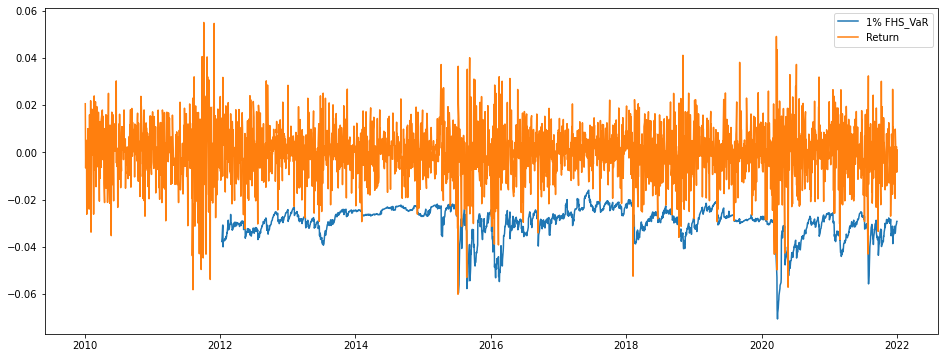

In [12]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(df_fhs['Date'], df_fhs['VaR_filtered_hs'], label = '1% FHS_VaR')
ax.plot(df_fhs['Date'], df_fhs['Return'], label = 'Return')
plt.legend()
num_below = len(np.where(df_fhs['Return']<df_fhs['VaR_filtered_hs'])[0])
num_above = len(np.where(df_fhs['Return']>=df_fhs['VaR_filtered_hs'])[0])
print('Percentage of day with return smaller than VaR = {}'.format(num_below/(num_below+num_above)))

The figure shows that Filtered Historical Simulation(FHS) is very sensitive to change in market volatility. When there is a great change in return, the VaR value drop significantly. If we compare FHS with GARCH VaR, we can notice that FHS is more sensitive to the market volatility than GARCH VaR, and it seems more "conservative" than GARCH VaR as it usually produces lower VaR value than GARCH VaR. Also, notice the frequency of VaR breach for FHS is around 1.14%, which is lower that of GARCH VaR (2.23%). Having said that, it is still higher than 1%.

### Cornish-Fisher Approximation to VaR

Cornish-Fisher method (CF) believes that it is not approriate to assume the distribution of return is a perfect normal distribution. The calculation of CF VaR is similar to FHS VaR but the quantile is estimated in different way. CF uses skewness and excess kurtosis when calculating the quantile. CF quantile can be viewed as Taylor expansion around the normal distribution. The formula for CF quantile is shown below.

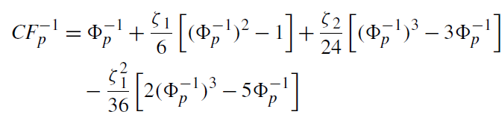

where xi_1 is the skewness and xi_2 is excess kurtosis of the standardized returns

In [13]:
def Cornish_Fisher_VaR(df, m, p = 0.01):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The price/index data containing column name 'Close'
    m: int
        Number of past data for fitting the GARCH model and calculating the percentile 
    p: float
        To calculate 100p% VaR
        
    Returns
    ----------
    pd.DataFrame
        DataFrame with new colums 'VaR_CF' specifying VaR of return
    '''
    z = norm.ppf(p)
    df['Return'] = np.log(df['Close']/df['Close'].shift(1))
    df.dropna(inplace=True)
    def helper(x):
        '''
        Parameters
        -----------
        x: pd.DataFrame
            The price/index data containing column name 'Return'

        Returns
        ----------
        float
            VaR of return one day ahead the last date in x
        '''
        ret = x.set_index('Date')['Return'] 
        model = arch.arch_model(ret, rescale=False)
        res = model.fit(last_obs=ret.index[-1]) # use all data to fit the model
        forecasts = res.forecast(horizon=5, start=ret.index[0], reindex=False) 
        tmr_variance = forecasts.variance['h.1'].reset_index() # one day ahead estimation for variance
        last_variance = tmr_variance.iloc[-1,1] # estimated variance on next day of last date in x
        tmr_variance.rename(columns={'h.1':'tmr_variance'}, inplace=True)
        x = pd.merge(x, tmr_variance, on='Date')
        x['tdy_sd'] = np.sqrt(x['tmr_variance'].shift(1))
        x['standardized_return'] = x['Return']/x['tdy_sd']
        skew = x['standardized_return'].skew()
        kurt = x['standardized_return'].kurt()
        percentile = (z + skew/6*(z**2-1) + kurt/24*(z**3-3*z) - (skew**2)/36*(2*z**3-5*z)) # calculate CF quantile
        return last_variance**0.5 * percentile
    tmr_VaR_CF = []
    for i in df.rolling(window=m):
        if len(i)<m: # if do not have enough number of past data
            tmr_VaR_CF.append(np.nan)
        else:
            tmr_VaR_CF.append(helper(i))
    df['tmr_VaR_CF'] = tmr_VaR_CF
    df['VaR_CF'] = df['tmr_VaR_CF'].shift(1)
    return df

In [ ]:
df_CF = df_hsi.copy(deep=True)
m = 500 # number of past data
df_CF = Cornish_Fisher_VaR(df_CF, m)

Percentage of day with return smaller than VaR = 0.008553971486761711


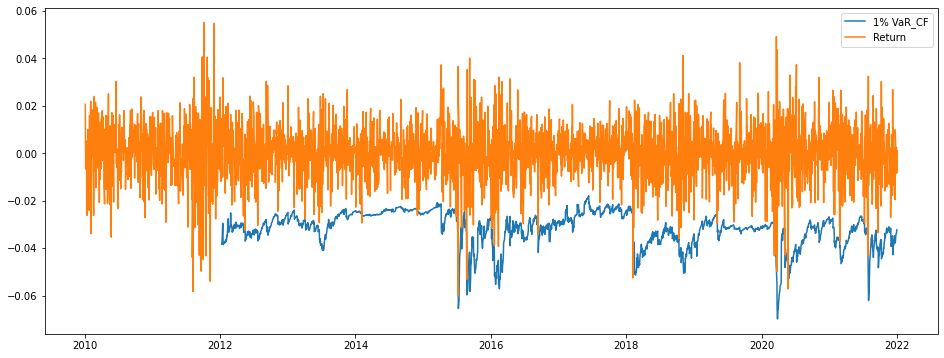

In [15]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(df_CF['Date'], df_CF['VaR_CF'], label = '1% VaR_CF')
ax.plot(df_CF['Date'], df_CF['Return'], label = 'Return')
plt.legend()
num_below = len(np.where(df_CF['Return']<df_CF['VaR_CF'])[0])
num_above = len(np.where(df_CF['Return']>=df_CF['VaR_CF'])[0])
print('Percentage of day with return smaller than VaR = {}'.format(num_below/(num_below+num_above)))

From the figure, we notice that CF VaR also produces a very dynamic pattern of VaR. It is able to response to changes in market volatility quickly. Moreover, it is worth mentioning that the frequency of VaR breach is around 0.86% in the simulation, which is lower than 1%. This shows that CF method is an improvement for estimating VaR. 

### Extreme Value Theory for VaR Estimation

Extreme Value Theory (EVT) believes that the biggest risks to a portfolio is the sudden occurrence of a single large negative return. As a result, only the tail of the distribution is important to measure the risk. The central result in extreme value theory states that the extreme tail of a wide range of distributions can approximately be described by Generallized Pareto Distribution (GPD). In case of risk management, as we are mainly interested in modelling thick-tail distribution, we can use Hill estimator to approximate the GPD distribution. After that, we can calculate the 100p-percentile of GPD distribution and multiply it with standard deviation estimated from GARCH model to obtain the VaR.

###### Use Hill Estimator to Approximate GPD Distribution
The following formula shows the approximation of GPD distribution by Hill estimator. 

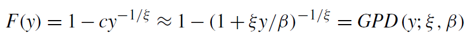

The parameters c and xi in Hill estimator can be estimated by Maximum Likelihood Estimation. Note that EVT only care about the tail of the distribution. We may set the threshold of tail to be u, and we only use data with standardized returns that are beyond the threshold (i.e. y<u) for calculating the parameters. A rule of thumb is to set u such that Tu = 50, where Tu is number of data y smaller than u. The final result is as follows.

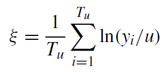 

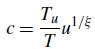

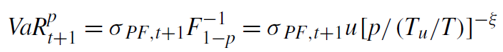

In [16]:
def EVT_VaR(df, m, p = 0.01):
    '''
    Parameters
    -----------
    df: pd.DataFrame
        The price/index data containing column name 'Close'
    m: int
        Number of past data for fitting the GARCH model and calculating the percentile 
    p: float
        To calculate 100p% VaR
        
    Returns
    ----------
    pd.DataFrame
        DataFrame with new colums 'VaR_EVT' specifying VaR of return
    '''
    df['Return'] = np.log(df['Close']/df['Close'].shift(1))
    df.dropna(inplace=True)
    def helper(x):
        '''
        Parameters
        -----------
        x: pd.DataFrame
            The price/index data containing column name 'Return'

        Returns
        ----------
        float
            VaR of return one day ahead the last date in x
        '''
        ret = x.set_index('Date')['Return'] 
        model = arch.arch_model(ret, rescale=False)
        res = model.fit(last_obs=ret.index[-1]) # use all data to fit the model
        forecasts = res.forecast(horizon=5, start=ret.index[0], reindex=False) 
        tmr_variance = forecasts.variance['h.1'].reset_index() # one day ahead estimation for variance
        last_variance = tmr_variance.iloc[-1,1] # estimated variance on next day of last date in x
        tmr_variance.rename(columns={'h.1':'tmr_variance'}, inplace=True)
        x = pd.merge(x, tmr_variance, on='Date')
        x['tdy_sd'] = np.sqrt(x['tmr_variance'].shift(1))
        x['standardized_return'] = x['Return']/x['tdy_sd']
        T = len(x)
        Tu = 50
        u = x['standardized_return'].sort_values().values[Tu]
        xi = 1/Tu*np.log(x['standardized_return'].sort_values().values[:Tu]/u).sum()
        c = Tu/T*abs(u)**(1/xi)
        VaR = (last_variance**0.5)*u*(p/(Tu/T))**(-xi)
        return VaR
    tmr_VaR_EVT = []
    for i in df.rolling(window=m):
        if len(i)<m: # if do not have enough number of past data
            tmr_VaR_EVT.append(np.nan)
        else:
            tmr_VaR_EVT.append(helper(i))
    df['tmr_VaR_EVT'] = tmr_VaR_EVT
    df['VaR_EVT'] = df['tmr_VaR_EVT'].shift(1)
    return df

In [ ]:
df_EVT = df_hsi.copy(deep=True)
m = 500 # number of past data
df_EVT = EVT_VaR(df_EVT, m)

Percentage of day with return smaller than VaR = 0.005702647657841141


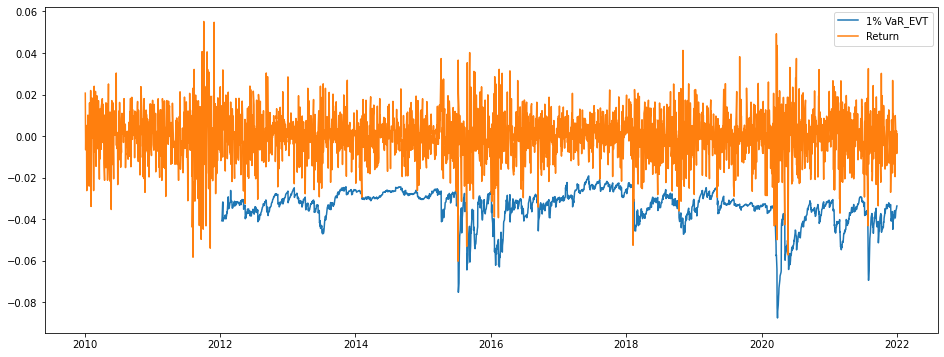

In [18]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(df_EVT['Date'], df_EVT['VaR_EVT'], label = '1% VaR_EVT')
ax.plot(df_EVT['Date'], df_EVT['Return'], label = 'Return')
plt.legend()
num_below = len(np.where(df_EVT['Return']<df_EVT['VaR_EVT'])[0])
num_above = len(np.where(df_EVT['Return']>=df_EVT['VaR_EVT'])[0])
print('Percentage of day with return smaller than VaR = {}'.format(num_below/(num_below+num_above)))

We can see that EVT method is able to respond to changes in market volatility quickly, which can be shown from the dynamic pattern of VaR value from the graph above. Moreover, it is impressive that the frequency of VaR breach is around 0.57% in the simulation, which is even lower than CF VaR.

### Comparison of Model-based Methods
So far we have calculated the VaR by using 4 model-based methods. The main difference among these methods is the calculation of 100p-percentile. GARCH_VaR uses 100p-percentile of normal distribution; FHS uses emperical 100p-percentile from the past data; CF_VaR uses skewness, excess kurtosis and taylor expansion of normal distribution to calculate 100p-percentile; EVT_VaR applies Hill estimator to approximate the GPD distribution for calculating 100p-percentile. Note that the standard deviation used in these methods are all the same (estimated from GARCH model). The figure below shows the comparison of VaR value obtained from these methods.

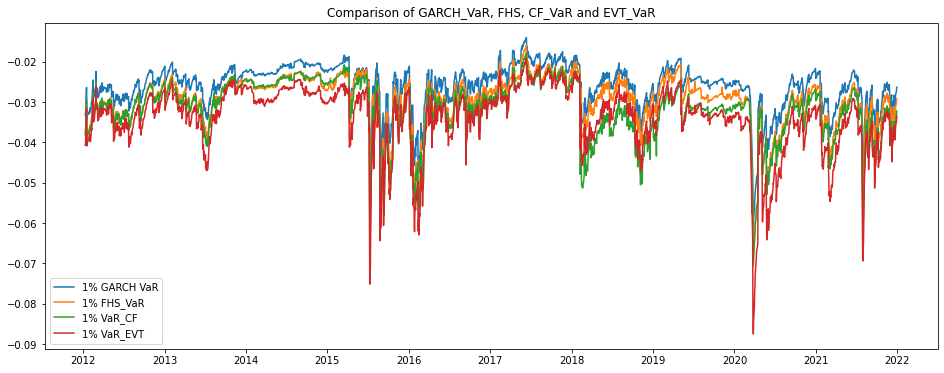

In [19]:
# Compare GARCH_VaR, FHS, CF_VaR and EVT_VaR
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(df_GARCH['Date'], df_GARCH['VaR_GARCH'], label = '1% GARCH VaR')
ax.plot(df_fhs['Date'], df_fhs['VaR_filtered_hs'], label = '1% FHS_VaR')
ax.plot(df_CF['Date'], df_CF['VaR_CF'], label = '1% VaR_CF')
ax.plot(df_EVT['Date'], df_EVT['VaR_EVT'], label = '1% VaR_EVT')
plt.title("Comparison of GARCH_VaR, FHS, CF_VaR and EVT_VaR")
plt.legend()
